# Plot temperature response over time

## Method: 


## IRF:
Using forcings from RCMIP models and the impulse response function:
\begin{align*}
\text{IRF}(t)=& 0.885\cdot (\frac{0.587}{4.1}\cdot exp(\frac{-t}{4.1}) + \frac{0.413}{249} \cdot exp(\frac{-t}{249}))\\
\text{IRF}(t)= &  \sum_{i=1}^2\frac{\alpha \cdot c_i}{\tau_i}\cdot exp\big(\frac{-t}{\tau_1}\big) 
\end{align*}
with $\alpha = 0.885$, $c_1=0.587$, $\tau_1=4.1$, $c_2=0.413$ and $\tau_2 = 249$.

the estimated ERF$_x$ for some forcing agent $x$ as follows: 

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

# Code + figures

## Imports:

In [400]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

In [402]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [403]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [149]:
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']
scenarios_nhist =['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585']# list(set(scenarios_fl)- {'historical'})
climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

In [373]:
from ar6_ch6_rcmipfigs.utils.misc_func import trans_scen2plotlabel
years= ['2040', '2100']

scn_trans = [trans_scen2plotlabel(label) for label in scenarios_nhist]
scn_trans = [label for label in scenarios_nhist]

variables_tot = ['Total']
variables_sum = ['Sum SLCFs']
iterables = [years, [var.split('|')[-1] for var in variables_erf_comp]]
iterables2 = [years, variables_tot]
iterables3 = [years, variables_sum]
#iterables2 = [scenarios_fl, [var.split('|')[-1] for var in variables_erf_comp]]

#iterables2 = [scenarios_fl, [var.split('|')[-1] for var in variables_erf_comp]]


def setup_table(scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables, names=['', ''])
    table = pd.DataFrame(columns=scn_trans, index = _i)#.transpose()
    table.index.name=scenario_n
    return table
#table['ECS = 2K']


def setup_table2(scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables2, names=['', ''])
    table = pd.DataFrame(columns=scn_trans, index = _i)#.transpose()
    table.index.name=scenario_n
    return table

def setup_table3(scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables3, names=['', ''])
    table = pd.DataFrame(columns=scn_trans, index = _i)#.transpose()
    table.index.name=scenario_n
    return table


setup_table()

ssp119 ssp126 ssp245 ssp370 ssp370-lowNTCF-aerchemmip  \
                                                                                
2040 CH4                   NaN    NaN    NaN    NaN                       NaN   
     Aerosols              NaN    NaN    NaN    NaN                       NaN   
     Tropospheric Ozone    NaN    NaN    NaN    NaN                       NaN   
     HFC                   NaN    NaN    NaN    NaN                       NaN   
     BC on Snow            NaN    NaN    NaN    NaN                       NaN   
2100 CH4                   NaN    NaN    NaN    NaN                       NaN   
     Aerosols              NaN    NaN    NaN    NaN                       NaN   
     Tropospheric Ozone    NaN    NaN    NaN    NaN                       NaN   
     HFC                   NaN    NaN    NaN    NaN                       NaN   
     BC on Snow            NaN    NaN    NaN    NaN                       NaN   

                        ssp585  
                                
2040 CH4                   NaN  
     Aerosols              NaN  
     Tropospheric Ozone    NaN  
     HFC                   NaN  
     BC on Snow            NaN  
2100 CH4                   NaN  
     Aerosols              NaN  
     Tropospheric Ozone    NaN  
     HFC                   NaN  
     BC on Snow            NaN

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [184]:
ds_DT = xr.open_dataset(PATH_DT)

In [183]:
name_deltaT = 'Delta T'

def new_varname(var, nname):
    """
    var:str
        Old variable of format varname|bla|bla
    nname:str
        name for the resulting variable, based on var
    Returns
    -------
    new variable name with nname|bla|bla
    """
    return nname + '|' + '|'.join(var.split('|')[1:])



In [185]:
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

## Compute sum of all SLCF forcers

In [186]:
from ar6_ch6_rcmipfigs.utils.misc import make_folders
from ar6_ch6_rcmipfigs.utils.misc_func import trans_scen2plotlabel, get_cmap_dic, get_scenario_ls_dic, get_scenario_c_dic

In [379]:

# ds_DT = dic_ds[0.885]
s_y = '1850'
# cdic = get_scenario_c_dic()

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)


def sum_name(var): return '|'.join(var.split('|')[0:2]) + '|' + 'All'


var = variables_erf_comp[0]
f_totn = sum_name(var)
dt_totn = sum_name(new_varname(var, name_deltaT))

# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))

In [380]:
ref_year='2021'
scntab_dic = {}
tab_tot = setup_table2()
tab_tot_sd = setup_table2()

for scn in scenarios_rel:
    for var in ['Delta T|Anthropogenic']:
        tabvar = 'Total'# var.split('|')[-1]
        dtvar = new_varname(var, name_deltaT)
        tabscn = scn#trans_scen2plotlabel(scn)
        for year in years: 
            _tab_da =ds_DT[dtvar].sel(scenario=scn, time=slice(year,year))-  ds_DT[dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
            #print(_tab_da)
            #print(_tab_da.mean('climatemodel').values[0])
            tab_tot.loc[(year, tabvar),tabscn]=_tab_da.mean('climatemodel').values[0]
            tab_tot_sd.loc[(year, tabvar),tabscn]=_tab_da.std('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()
tab_tot_sd

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Total,0.0949343,0.0733085,0.042811,0.0406404,0.054927,0.0266538
2100,Total,0.107939,0.128872,0.118113,0.186669,0.211884,0.223506


In [381]:
ref_year='2021'
scntab_dic = {}

tab_slcf_sum = setup_table3()
tab_slcf_sum_sd = setup_table3()

for scn in scenarios_rel:
    for var in ['Delta T|Anthropogenic|All']:
        tabvar = 'Sum SLCFs'# var.split('|')[-1]
        dtvar = new_varname(var, name_deltaT)
        tabscn = scn#trans_scen2plotlabel(scn)
        _da = ds_DT[var].sum('variable')
        for year in years: 
            _tab_da =_da.sel(scenario=scn, time=slice(year,year))-  _da.sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
            #print(_tab_da)
            #print(_tab_da.mean('climatemodel').values[0])
            tab_slcf_sum.loc[(year, tabvar),tabscn]=_tab_da.mean('climatemodel').values[0]
            tab_slcf_sum_sd.loc[(year, tabvar),tabscn]=_tab_da.std('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()
tab_slcf_sum

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Sum SLCFs,0.127588,0.124682,0.132424,0.141096,0.210902,0.213669
2100,Sum SLCFs,-0.02995,0.000475109,0.196311,0.55079,0.702284,0.574703


In [382]:
ref_year='2021'
scntab_dic = {}
tab = setup_table()
tab_sd = setup_table()
for scn in scenarios_rel:
    tabscn =scn# trans_scen2plotlabel(scn)

    for var in variables_erf_comp:
        tabvar = var.split('|')[-1]
        dtvar = new_varname(var, name_deltaT)
        for year in years: 
            _tab_da =ds_DT[dtvar].sel(scenario=scn, time=slice(year,year))-  ds_DT[dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
            #print(_tab_da)
            #print(_tab_da.mean('climatemodel').values[0])

            
            tab.loc[(year, tabvar),tabscn]=_tab_da.mean('climatemodel').values[0]
            tab_sd.loc[(year, tabvar),tabscn]=_tab_da.std('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()
tab

ssp119      ssp126      ssp245      ssp370  \
                                                                          
2040 CH4                 -0.0447013  -0.0291883   0.0486324   0.0917135   
     Aerosols              0.262955    0.205296   0.0611389  -0.0186025   
     Tropospheric Ozone  -0.0839045   -0.056743  0.00156772   0.0413476   
     HFC                 0.00582878   0.0185408   0.0306454   0.0286523   
     BC on Snow          -0.0190398  -0.0158591 -0.00571875  0.00619175   
2100 CH4                   -0.21796   -0.206977 -0.00702949    0.362437   
     Aerosols              0.378002    0.382743    0.229839  -0.0124726   
     Tropospheric Ozone   -0.168869   -0.158057   -0.065602    0.106714   
     HFC                -0.00500177 -0.00222552   0.0646217    0.109127   
     BC on Snow          -0.0285351  -0.0257577  -0.0209888   0.0113509   

                        ssp370-lowNTCF-aerchemmip      ssp585  
                                                               
2040 CH4                                0.0917135   0.0741541  
     Aerosols                            0.105429   0.0791586  
     Tropospheric Ozone               -0.00538849   0.0257412  
     HFC                                0.0286523   0.0455577  
     BC on Snow                       -0.00629107 -0.00305192  
2100 CH4                                 0.362437    0.193089  
     Aerosols                            0.239401    0.164572  
     Tropospheric Ozone                 0.0202453   0.0191433  
     HFC                                 0.109127    0.251827  
     BC on Snow                        -0.0118344 -0.00593702

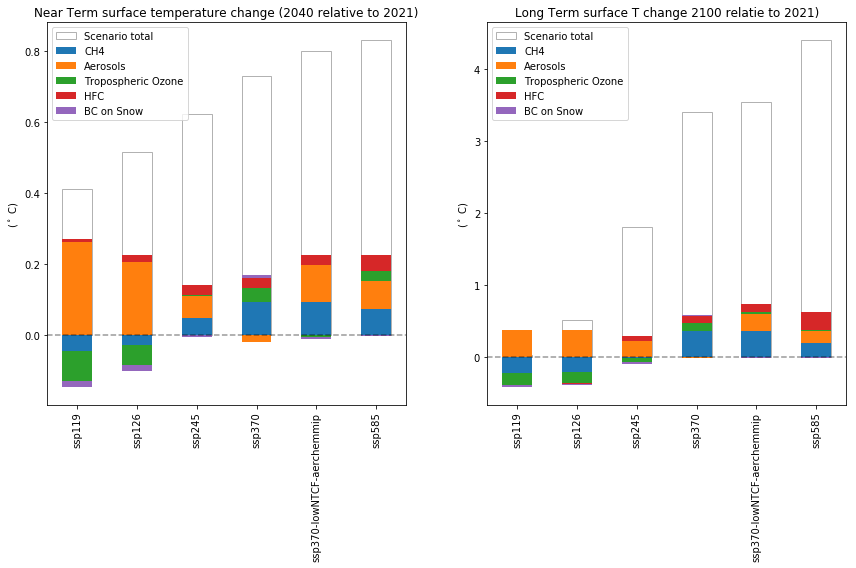

In [192]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[12,8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
for yr, ax, tit in zip(years, axs, tits):
    tot_yr = tab_tot.loc[yr].rename({'Total':'Scenario total'})
    tot_yr.transpose().plot(kind='bar',  ax=ax, color='w', alpha=.3, edgecolor='k')#, grid=True)#stac)
    tab.loc[yr].transpose().plot(kind='bar', stacked=True, ax=ax)#, grid=True)#stac)
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('($^\circ$ C)')
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
plt.savefig(fn, dpi=300)

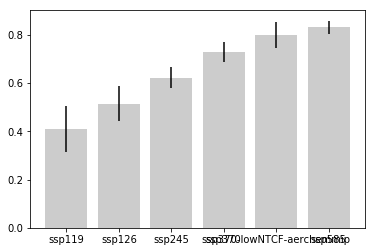

In [361]:
tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
tot_sd_yr = tab_tot_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    

plt.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tot_sd_yr.transpose()[ntot].values)
plt.show()

In [387]:
sum_sd_yr.transpose()['Sum SLCFs']

ssp119                        0.106843
ssp126                       0.0852915
ssp245                       0.0483122
ssp370                       0.0257856
ssp370-lowNTCF-aerchemmip    0.0639803
ssp585                       0.0525353
Name: Sum SLCFs, dtype: object

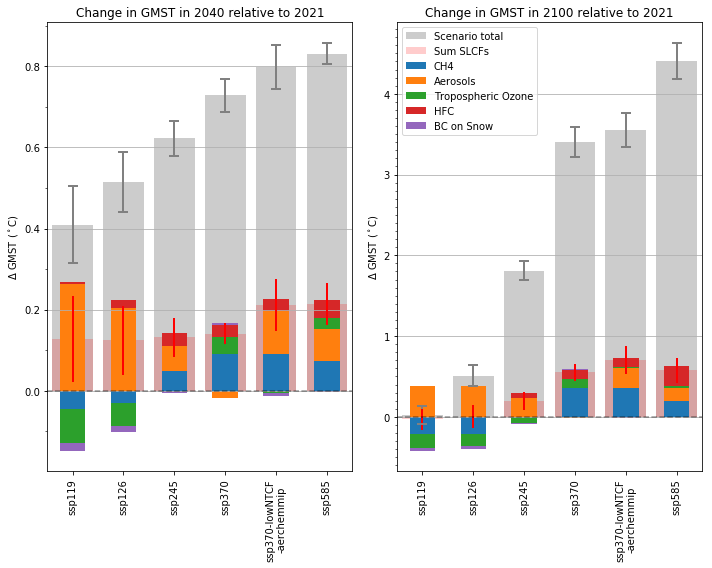

In [398]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[10,8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tab_tot_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    #l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tab_slcf_sum.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tab_slcf_sum_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tot_sd_yr.transpose()[ntot].values, 
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
          error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='bar', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('$\Delta$ GMST ($^\circ$C)')
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off')
plt.savefig(fn, dpi=300)

- De vi allerede har.

Hvis vi skulle lagt til usikkerhet?
- Ville lagt til usikkerhet gjennom ECS -- 
    - Regne ut de samme tallene for 3 verdier av ECS. 
    - Monte carlo trekk med en fordeling på ECS. 
    - 

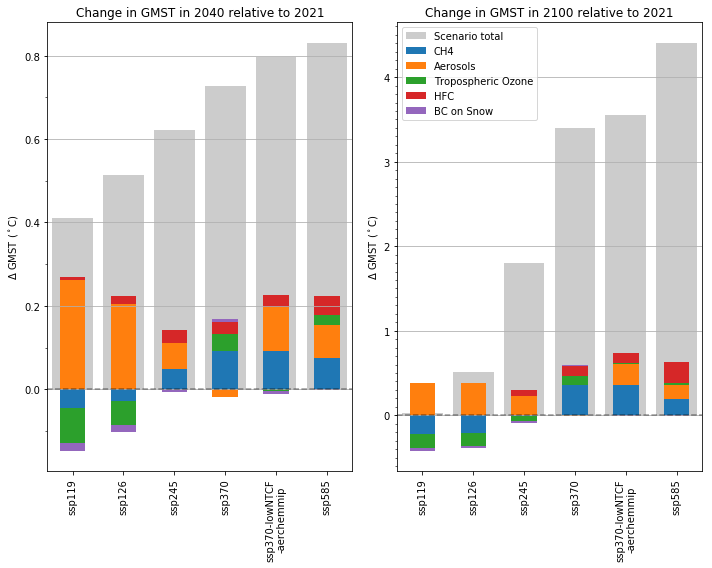

In [347]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[10,8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2)
    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='bar', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('$\Delta$ GMST ($^\circ$C)')
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off')
plt.savefig(fn, dpi=300)

In [216]:
ax.get_axes_locator()

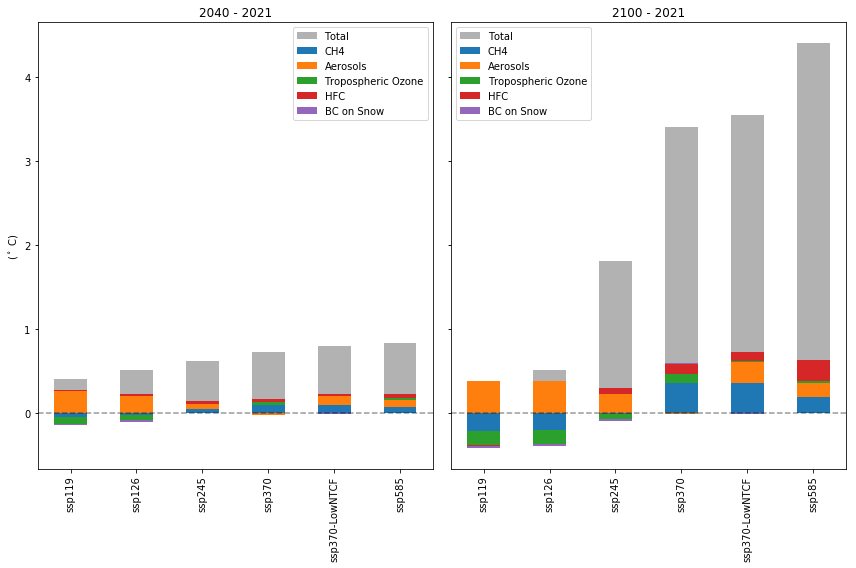

In [163]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[12,8], sharey=True)
for yr, ax in zip(years, axs):
    tab_tot.loc[yr].transpose().plot(kind='bar',  ax=ax, color='k', alpha=.3)#, grid=True)#stac)
    tab.loc[yr].transpose().plot(kind='bar', stacked=True, ax=ax)#, grid=True)#stac)
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(yr+' - 2021' )
    ax.set_ylabel('($^\circ$ C)')
fn = RESULTS_DIR+'/figures/stack_bar_influence_years_same_y.png'
plt.tight_layout()
plt.savefig(fn, dpi=300)

In [90]:
ref_year='2021'
scntab_dic = {}
tab_to = setup_table()
for scn in scenarios_rel:
    for var in ['Delta T|Anthropogenic']:
        tabvar = var.split('|')[-1]
        dtvar = new_varname(var, name_deltaT)
        for year in years: 
            _tab_da =ds_DT[dtvar].sel(scenario=scn, time=slice(year,year))-  ds_DT[dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
            #print(_tab_da)
            #print(_tab_da.mean('climatemodel').values[0])
            tab_tot.loc[(scn, tabvar),year]=_tab_da.mean('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()
tab

2040        2100
                                                                    
ssp370-lowNTCF-aerchemmip CH4                  0.0917135    0.362437
                          Aerosols              0.105429    0.239401
                          Tropospheric Ozone -0.00538849   0.0202453
                          HFC                  0.0286523    0.109127
                          BC on Snow         -0.00629107  -0.0118344
ssp245                    CH4                  0.0486324 -0.00702949
                          Aerosols             0.0611389    0.229839
                          Tropospheric Ozone  0.00156772   -0.065602
                          HFC                  0.0306454   0.0646217
                          BC on Snow         -0.00571875  -0.0209888
ssp370                    CH4                  0.0917135    0.362437
                          Aerosols            -0.0186025  -0.0124726
                          Tropospheric Ozone   0.0413476    0.106714
                          HFC                  0.0286523    0.109127
                          BC on Snow          0.00619175   0.0113509
ssp585                    CH4                  0.0741541    0.193089
                          Aerosols             0.0791586    0.164572
                          Tropospheric Ozone   0.0257412   0.0191433
                          HFC                  0.0455577    0.251827
                          BC on Snow         -0.00305192 -0.00593702
ssp126                    CH4                 -0.0291883   -0.206977
                          Aerosols              0.205296    0.382743
                          Tropospheric Ozone   -0.056743   -0.158057
                          HFC                  0.0185408 -0.00222552
                          BC on Snow          -0.0158591  -0.0257577
ssp119                    CH4                 -0.0447013    -0.21796
                          Aerosols              0.262955    0.378002
                          Tropospheric Ozone  -0.0839045   -0.168869
                          HFC                 0.00582878 -0.00500177
                          BC on Snow          -0.0190398  -0.0285351

In [18]:
#scntab_dic = {}
tab = setup_table2()#scenario_n=scn)

for scn in scenarios_fl:
    for var in variables_erf_comp:
        tabvar = var.split('|')[-1]
        dtvar = new_varname(var,name_deltaT)
        print(dtvar)
        for key in ECS2ecsf:
            for year in years: 
                
                _tab_da = dic_ds[key][dtvar].sel(scenario=scn, time=slice(year,year))-  dic_ds[key][dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
                #print(_tab_da)

                #_tab_da = dic_ds[key][var].sel(scenario=scn, time=slice(year,year))
                #print(_tab_da['climatemodel'])
                tab.loc[(scn, tabvar), (key,year)] =_tab_da.mean('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()


#tab

NameError: name 'iterables' is not defined

In [ ]:
ds_diff = ds_DT.sel(time='2100').squeeze()-ds_DT.sel(time='2021').squeeze()

# Plot

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        # .mean(climatemodel)
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        # print(base)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        scen_ds = _ds[varl] - base_keep
        test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val )}#, 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib.png', dpi=300)
    plt.show()

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        #scen_ds = _ds[varl] - base_keep
        #test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val ), 'rotation': 0}#28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.show()

In [ ]:
scenarios_fl

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = list(set( scenarios_fl) - {'historical','ssp370-lowNTCF-aerchemmip'})# 'ssp'#['ssp126','ssp245', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        #scen_ds = _ds[varl] - base_keep
        #test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['time'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        if 'Delta T' in ref_var:
            x_val = '2100'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val ), 'rotation': 0}#28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR +'/ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.show()

In [ ]:
_pl_da

# Alternative: Do one graph for each component AND the total? 

## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios (black line) relative to year 2021. The area signifies the warming (below the total) or cooling (above the stipled line) introduced by changes in the SLCFer in the specific scenario. Note that in the in the businiss as usual scenario, all the SLCFers except BC on snow add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. Both scenarios include emission controls which act to reduce aerosols relative 2021 and thus the aerosols give warming. However, the warming from aerosols is much stronger in ssp126 because of stricter emission control in this scenario. 

- 


## What question does the graph answer?
- How much can we gain by implementing addtional SLCF cuts?
    - The answer to the question depends on the emission scenario we follow, because the effect of additional cuts naturally depend on how much has already been cut of a specific SLCFer. If we take scenario 119 as a baseline for the feasible cuts to SLCFs, we can calculate how much heating/cooling each component contributes with relative to this scenario. This underlines a more general point: SLCFs like ADD EXAMPLES are highly coupled to CO$_2$ emissions, which imply that strict emission control on these will automatically also control emissions of the SLCFs.  
The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios. The area signifies the added/ $\Delta$T by the component. 


## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios. The area signifies the additional (above the stipled line) warming and reductions (below the stipled line) by changes in the component in the specific scenario. Note that in the in the businiss as usual scenario, all components act to add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. 
